# This notebook tests the light travel time, stellar aberration and angle conversion routines, showing their errors are well within one PanSTARRs pixel

Importing the relevant packages

In [1]:
import spiceypy as spice
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import astropy.units as u
from astropy.constants import c
from ephemerides import load_spice_kernels, build_spice_get_target

In [2]:
def LT(t, obsxyz, func):
    """
    Calculates the light time correction to the position vector of an object
    
    Arguments:
    
    t: days
    
    Julian date of observation
    
    obsxyz: np.array
    
    Position vector of observer with respect to the Solar System barycenter.
    
    func: function
    
    A get_target_xyz like function that returns the position and velocity vector of a body at a certain time
    
    Returns:
    
    txyz: np.array
    
    A corrected position vector of the observed object
    
    """
    
    txyz = func(t)
    dist = np.linalg.norm(txyz[0]-obsxyz)
    ltime = float(((dist*u.AU).to(u.m)/c)/u.s)
    d = 10
    while(abs(d)>1e-16):
        txyz = func(t-ltime)
        dist = np.linalg.norm(txyz[0]-obsxyz)
        ltime2 = float(((dist*u.AU).to(u.m)/c)/u.s)
        d = (ltime2-ltime)/ltime
        ltime = ltime2
    return txyz

A demonstration that the LT function works. We compare my correction to spice's correction. Correct well within one pixel

In [3]:
load_spice_kernels()
mtheta = []
atheta = []
for i in range(0,400):    
    ts = 140961664.18440723 + 10*i*3600*24
    get_earth = build_spice_get_target('3',"NONE","SOLAR SYSTEM BARYCENTER")
    get_jup = build_spice_get_target('5',"NONE","SOLAR SYSTEM BARYCENTER")
    exyz = get_earth(ts)
    jxyz = get_jup(ts)
    fxyz = LT(ts, exyz[0], get_jup)
    mtheta.append((np.linalg.norm(fxyz[0]-jxyz[0])/np.linalg.norm(jxyz[0]-exyz[0])))
    get_cor_jup = build_spice_get_target('5',"LT","EARTH BARYCENTER")
    get_wrong_jup = build_spice_get_target('5',"NONE","EARTH BARYCENTER")
    axyz = get_cor_jup(ts)
    wxyz = get_wrong_jup(ts)
    atheta.append((np.linalg.norm(axyz[0]-wxyz[0])/np.linalg.norm(wxyz[0])))

Comparison of my angle of correction to spice's angle. They overlap

Text(0, 0.5, 'θ in Arcseconds')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


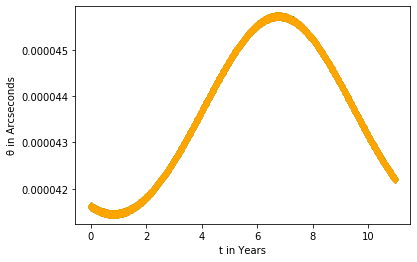

In [4]:
x = np.linspace(0,400,400)
plt.plot(x*10/365.25,atheta,"d",color = "green")
plt.plot(x*10/365.25,mtheta,"d",color = "orange")
plt.xlabel("t in Years")
plt.ylabel("θ in Arcseconds")

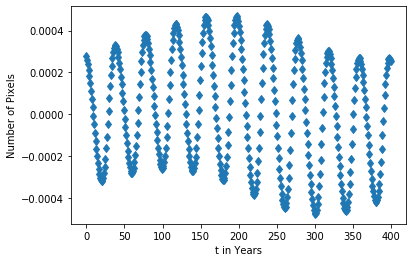

In [5]:
x = np.linspace(0,400,400)
error = []
for i in range(0,400):
    error.append((mtheta[i]-atheta[i])*1e6)
plt.xlabel("t in Years")
plt.ylabel("Number of Pixels")
plt.plot(x,error,"d")
#Error is random and no higher than 1e-8 order

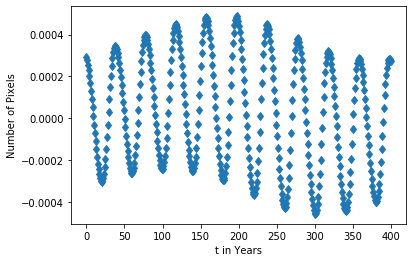

In [7]:
x = np.linspace(0,400,400)
error = []
for i in range(0,400):
    error.append((mtheta[i]-atheta[i])*1e6)
plt.xlabel("t in Years")
plt.ylabel("Number of Pixels")
plt.plot(x,error,"d")
#Error is random and no higher than 1e-8 order

In [8]:
def SB(earthxyz,vxyz,ts,get_jup):
    """
    Calculates the stellar aberration correction to the position vector of an object

    Arguments:
    
    earthxyz: np.array
    
    The position vector of the observer
    
    vxyz: np.array
    
    The velocity vector of the observer
    
    ts: days
    
    Julian date of observation
    
    get_jup:
    
    A get_target_xyz like function that returns the position and velocity vector of a body at a certain time

    Returns:
    
    v: np.array
    
    A corrected position vector of the observed object
    """
    myjupxyz = LT(ts, earthxyz, get_jup)
    xyz = earthxyz-myjupxyz[0]
    norm_vec = xyz/np.linalg.norm(xyz)
    cvec = float((c.to(u.AU/u.d))/(u.AU/u.d))*norm_vec
    vcorr = cvec - vxyz*3600*24
    v = (vcorr/np.linalg.norm(vcorr))*np.linalg.norm(xyz)
    return v

A demonstration that the SB function works. We compare my correction to spice's correction. Correct well within one pixel

In [9]:
Furnisher()
mapttheta = []
aapttheta = []
for i in range(0,400):
    ts = 140961664.18440723 + 10*i*3600*24
    get_earth = get_spice_function('3',"NONE","SOLAR SYSTEM BARYCENTER")
    get_jup = get_spice_function('5',"NONE","SOLAR SYSTEM BARYCENTER")
    exyz = get_earth(ts)
    jxyz = get_jup(ts)
    newjupxyz = SB(exyz[0],exyz[1],ts,get_jup)
    get_cor_jup = get_spice_function('5',"LT+S","EARTH BARYCENTER")
    axyz = get_cor_jup(ts)
    jxyz = -(jxyz[0]-exyz[0])
    k = np.linalg.norm(newjupxyz-jxyz)/np.linalg.norm(newjupxyz)
    mapttheta.append(206265*k)
    k = np.linalg.norm(-axyz[0]-jxyz)/np.linalg.norm(axyz[0])
    aapttheta.append(206265*k)

My angle and spice's angle overlap

Text(0, 0.5, 'θ in Arcseconds')

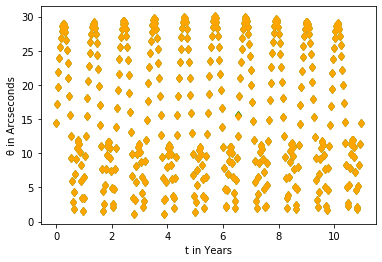

In [10]:
x = np.linspace(0,400,400)
plt.plot(x*10/365.25,mapttheta,"d",color = "green")
plt.plot(x*10/365.25,aapttheta,"d",color = "orange")
plt.xlabel("t in Years")
plt.ylabel("θ in Arcseconds")

Error is always within one pixel

Text(0, 0.5, 'Number of Pixels')

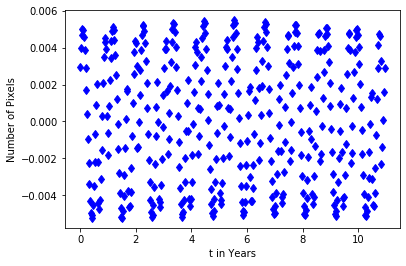

In [11]:
x = np.linspace(0,400,400)
plt.plot(x*10/365.25,(np.array(mapttheta)-np.array(aapttheta))*1e6*1/206265,"d",color = "blue")
plt.xlabel("t in Years")
plt.ylabel("Number of Pixels")

In [12]:
def CordConv(xyz):
    '''
    This function takes in a position vector of a body relative to an observer and returns a radec.
    
    Arguments:
    
    xyz: numpy array
    
    Should be three values, the x,y,z of the position vector
    
    Returns:
    
    radec: numpy array
    
    Two values, the first for right ascension and the second for declination
    
    '''
    DEC = -(np.arccos(xyz[2]/np.linalg.norm(xyz))-np.pi/2)
    RA = (np.arctan2(xyz[1],xyz[0]))
    while (RA > 2*np.pi):
        RA -= 2*np.pi   
    while (RA < 0):
        RA += 2*np.pi   
    return np.array([RA*180/np.pi,DEC*180/np.pi])

Demonstration that my radec conversion function works

In [13]:
mRA = []
mDEC = []
aRA = []
aDEC = []
for i in range(0,400):    
    ts = 140961664.18440723 + 10*i*3600*24
    get_jup = get_spice_function('5',"LT","EARTH")
    exyz = get_jup(ts)
    aRA.append(exyz[2][0])
    aDEC.append(exyz[2][1])
    myradec = CordConv(exyz[0])
    mRA.append(myradec[0])
    mDEC.append(myradec[1])

My ra and spice's overlap

Text(0, 0.5, 'θ in Degrees')

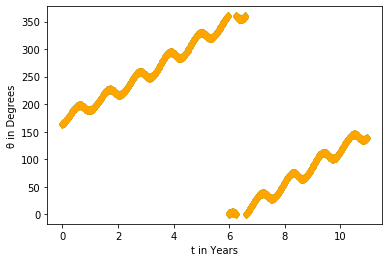

In [14]:
x = np.linspace(0,400,400)
plt.plot(x*10/365.25,mRA,"d",color = "green")
plt.plot(x*10/365.25,aRA,"d",color = "orange")
plt.xlabel("t in Years")
plt.ylabel("θ in Degrees")

Error is very minor, close to machine capabilities

Text(0, 0.5, 'θ in Degrees')

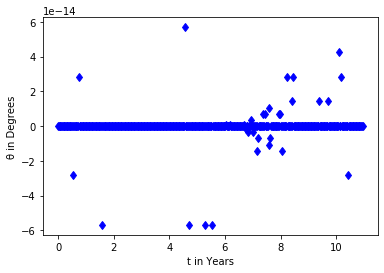

In [15]:
x = np.linspace(0,400,400)
plt.plot(x*10/365.25,(np.array(mRA)-np.array(aRA)),"d",color = "blue")
plt.xlabel("t in Years")
plt.ylabel("θ in Degrees")

Same for dec

Text(0, 0.5, 'θ in Degrees')

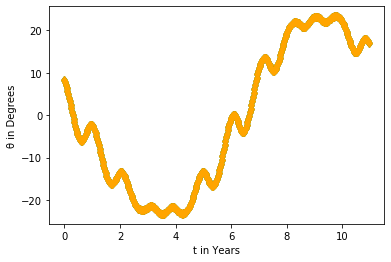

In [16]:
x = np.linspace(0,400,400)
plt.plot(x*10/365.25,mDEC,"d",color = "green")
plt.plot(x*10/365.25,aDEC,"d",color = "orange")
plt.xlabel("t in Years")
plt.ylabel("θ in Degrees")

Text(0, 0.5, 'θ in Degrees')

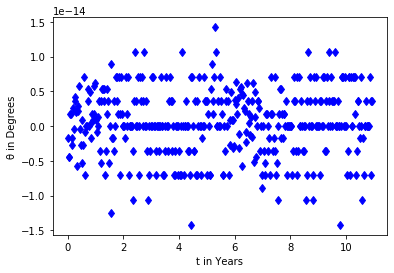

In [17]:
x = np.linspace(0,400,400)
plt.plot(x*10/365.25,(np.array(mDEC)-np.array(aDEC)),"d",color = "blue")
plt.xlabel("t in Years")
plt.ylabel("θ in Degrees")